## Import Libraries and Load the Data

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.linear_model
import warnings

In [0]:
from scipy.stats import skew
from scipy.stats.stats import pearsonr

import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [0]:
facebook = pd.read_csv('./facebook_train.csv')
facebook.head()

,total_followers,type,category,month,weekday,hour,paid,comment,like,share
0,124050,Photo,3,6,4,17,1,3,77,16
1,132556,Photo,2,8,3,24,0,11,313,50
2,92786,Photo,2,2,6,17,1,2,145,39
3,135632,Photo,1,9,2,1,0,2,299,49
4,139540,Link,1,12,3,17,1,7,229,21


In [0]:
facebook.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 10 columns):
total_followers    397 non-null int64
type               397 non-null object
category           397 non-null int64
month              397 non-null int64
weekday            397 non-null int64
hour               397 non-null int64
paid               397 non-null int64
comment            397 non-null int64
like               397 non-null int64
share              397 non-null int64
dtypes: int64(9), object(1)
memory usage: 31.1+ KB


## Data Preprocessing

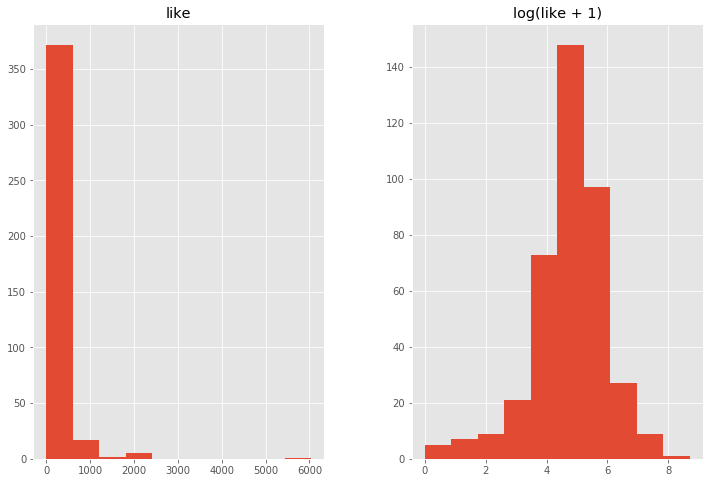

In [0]:
#np.log1p() returns the natural logarithm of one plus the input array, element-wise
like = pd.DataFrame({"like":facebook["like"], "log(like + 1)":np.log1p(facebook["like"])})
like.hist();

In [0]:
#log transform the target
facebook["like"] = np.log1p(facebook["like"])

#find numeric features
numeric_features = facebook.dtypes[facebook.dtypes != "object"].index

#compute skew
skewed_features = facebook[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

#log transform skewed numeric features
facebook[skewed_features] = np.log1p(facebook[skewed_features])

#create dummies for categorical features
facebook = pd.get_dummies(facebook)
facebook = pd.get_dummies(facebook, columns=["category", "month", "weekday", "hour"])

#replace NANs with the mean of the column
facebook = facebook.fillna(facebook.mean())

In [0]:
#standardize total_followers by removing the mean and scaling to unit variance
scaler = sklearn.preprocessing.StandardScaler()
trans_total_followers = scaler.fit_transform(np.array(facebook.total_followers).reshape(-1,1))
facebook['trans_total_followers'] = trans_total_followers
facebook.head() #debug check

,total_followers,paid,comment,like,share,type_Link,type_Photo,type_Status,type_Video,category_1,category_2,category_3,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_12,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24,trans_total_followers
0,124050,0.693147,1.386294,4.356709,2.833213,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.036279
1,132556,0.000000,2.484907,5.749393,3.931826,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.555526
2,92786,0.693147,1.098612,4.983607,3.688879,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-1.872224
3,135632,0.000000,1.098612,5.703782,3.912023,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.743300
4,139540,0.693147,2.079442,5.438079,3.091042,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.981863


In [0]:
facebook.columns

Index(['total_followers', 'paid', 'comment', 'like', 'share', 'type_Link',
       'type_Photo', 'type_Status', 'type_Video', 'category_1', 'category_2',
       'category_3', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_12',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'hour_24', 'trans_total_followers'],
      dtype='object')

## Create Train/Validation Splits

In [0]:
from sklearn.model_selection import train_test_split

X = facebook[['type_Link', 'type_Photo', 'type_Status',
             'type_Video', 'category_1', 'category_2',
             'category_3', 'month_1', 'month_2', 'month_3',
             'month_4', 'month_5', 'month_6', 'month_7',
             'month_8', 'month_9', 'month_10', 'month_11',
             'month_12', 'weekday_1', 'weekday_2', 'weekday_3',
             'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
             'trans_total_followers', 'hour_1', 'hour_2', 'hour_3',
       'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_12',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'hour_24', 'paid']]
y = facebook.like

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((317, 48), (80, 48), (317,), (80,))

## Ridge Regression Model

In [0]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score

def mse_cv(model):
    mse = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5)
    return mse

Lowest MSE =  1.358878883047091


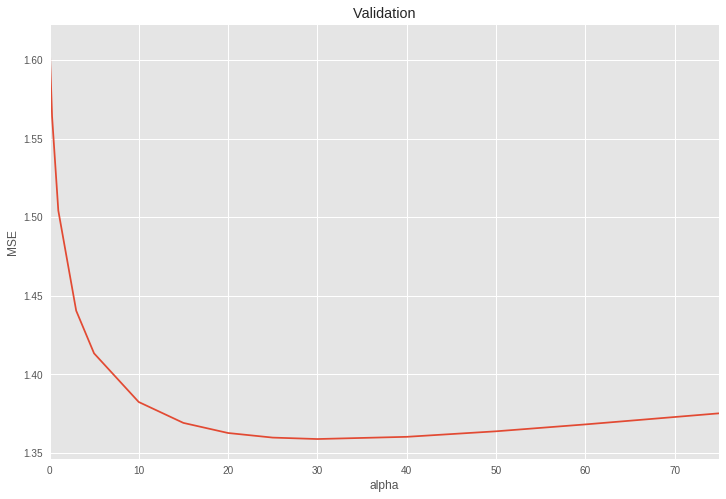

In [0]:
#model 1: Ridge Regression Estimator
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 25, 30, 40, 50, 60, 75]

#perform 5-fold CV to find the alpha value that minimizes MSE
cv_ridge = [mse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("MSE");
print("Lowest MSE = ", cv_ridge.min())

In [0]:
warnings.simplefilter("ignore")
model_ridge = Ridge(alpha=30).fit(X_train, y_train) #use the alpha from the above cell
mse_cv(model_ridge).mean()

1.358878883047091

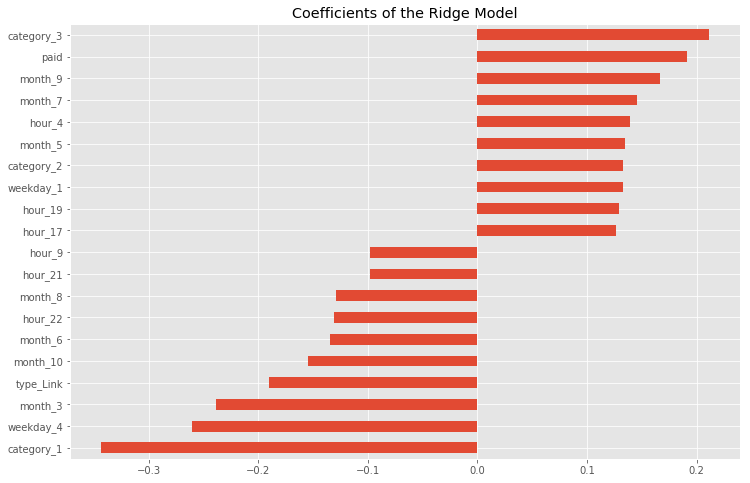

In [0]:
coef = pd.Series(model_ridge.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp_coef.plot(kind = "barh")
plt.title("Coefficients of the Ridge Model");

## Model Evaluation Metrics

In [0]:
y_pred = model_ridge.predict(X_test) #predict on the validation set

In [0]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, r2_score

print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Median Absolute Error: ", median_absolute_error(y_test, y_pred))
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("R^2: ", r2_score(y_test, y_pred))

Mean Absolute Error:  0.8207093361858682
Median Absolute Error:  0.6366326990548452
Mean Squared Error:  1.1238466770466922
R^2:  0.23003813413546192


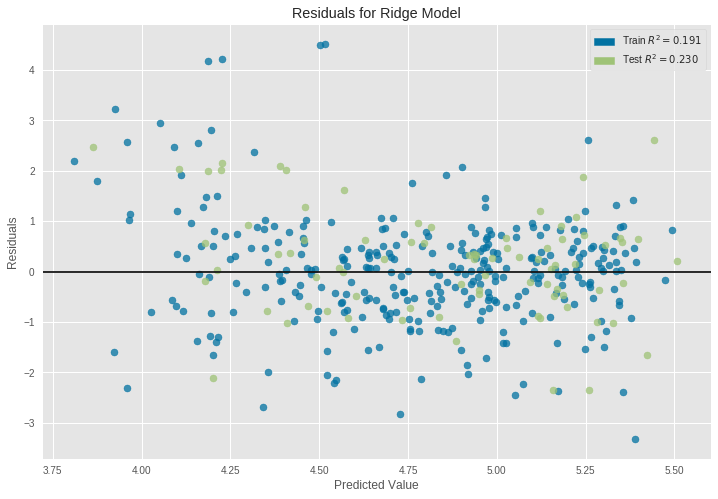

In [0]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model_ridge, hist=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

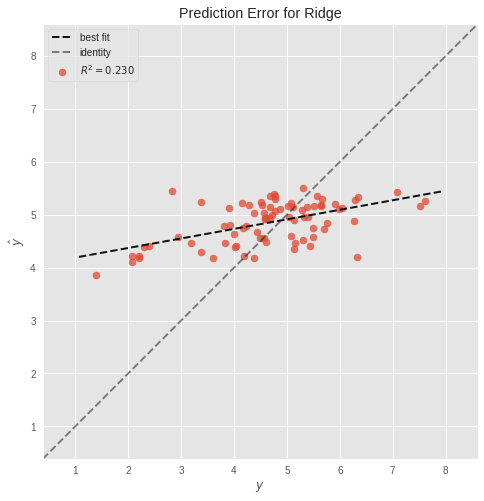

In [0]:
from yellowbrick.regressor import PredictionError

visualizer = PredictionError(model_ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof() 

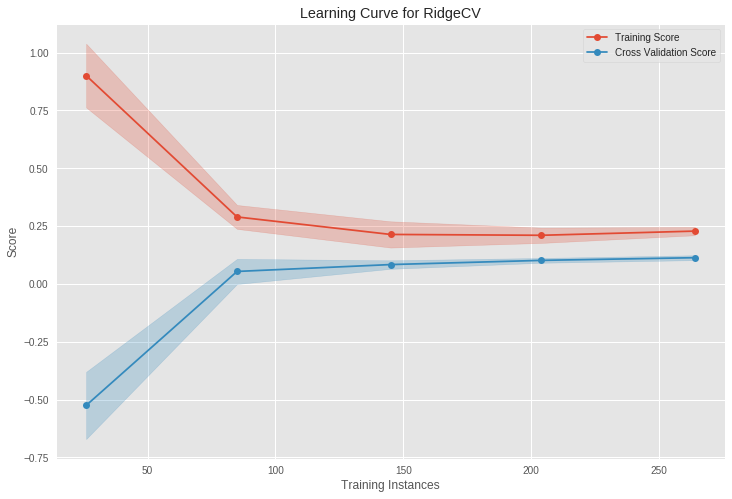

In [0]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(RidgeCV(alphas=alphas), scoring='r2')

visualizer.fit(X, y)
visualizer.poof()  

## XGBoostRegressor Model

In [0]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

params = {"max_depth":1, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

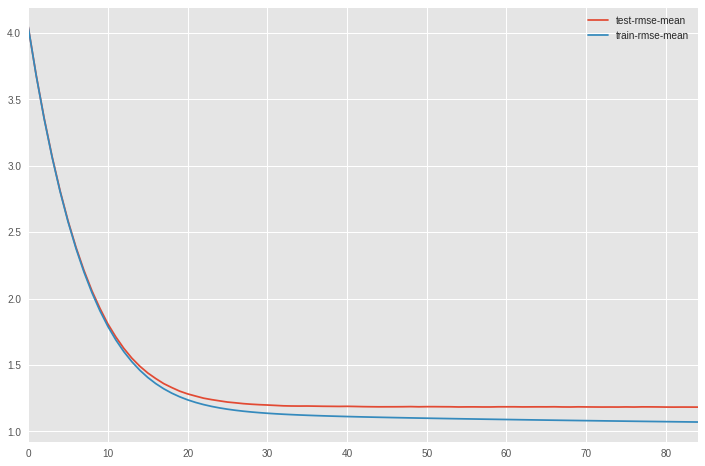

In [0]:
model.loc[:,["test-rmse-mean", "train-rmse-mean"]].plot();

In [0]:
model_xgb = xgb.XGBRegressor(max_depth=1, learning_rate=0.1, objective='reg:squarederror')
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=1, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [0]:
xgb_preds = model_xgb.predict(X_test)
ridge_preds = model_ridge.predict(X_test)

In [0]:
print("XGB MSE on validation set: ", sklearn.metrics.mean_squared_error(y_test, xgb_preds))
print("Ridge MSE on validation set: ", sklearn.metrics.mean_squared_error(y_test, ridge_preds))

XGB MSE on validation set:  1.2612510276796738
Ridge MSE on validation set:  1.1238466770466922


In [0]:
print("XGB R^2: ", r2_score(y_test, xgb_preds))
print("Ridge R^2: ", r2_score(y_test, ridge_preds))

XGB R^2:  0.13590063980278944
Ridge R^2:  0.23003813413546192


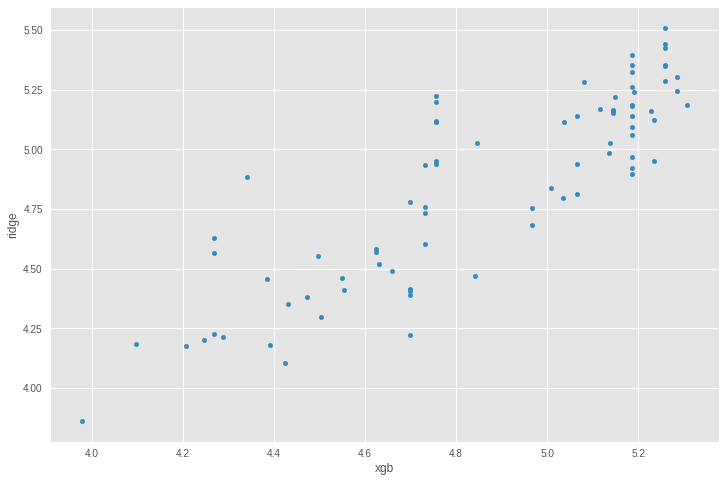

In [0]:
predictions = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})
predictions.plot(x = "xgb", y = "ridge", kind = "scatter");

In [0]:
blend_preds = 0.8*ridge_preds + 0.2*xgb_preds
print("Blended MSE on validation set: ", sklearn.metrics.mean_squared_error(y_test, blend_preds))
print("MAE: ", mean_absolute_error(y_test, blend_preds))
print("Median AE: ", median_absolute_error(y_test, blend_preds))
print("Blended R^2 on validation set: ", r2_score(y_test, blend_preds))

Blended MSE on validation set:  1.144780021701526
MAE:  0.8252929231758218
Median AE:  0.6149217537958473
Blended R^2 on validation set:  0.21569642948979184


Note: Score has improved by taking the weighted average of uncorrelated results!